# Gunc simulated genomes type 3b: parse contig headers for clean and dirty and analyze

In [1]:
setwd("..")

In [234]:
# disable scientific notation (for plot axes)
options(scipen = 999)

In [232]:
library(dplyr)
library(readr)
library(tidyr)
library(purrr)
library(rentrez)
library(ggplot2)
library(ggpubr)

## obtain and read in GTDB rs207 metadata

In [67]:
destfile <- "inputs/gtdb-rs207/bac120_metadata_rs207.tar.gz"
url <- "https://data.gtdb.ecogenomic.org/releases/release207/207.0/bac120_metadata_r207.tar.gz"
if (!file.exists(destfile)) {
  download.file(url, destfile, method="auto") 
}
outfile <- "inputs/gtdb-rs207/bac120_metadata_r207.tsv"
if (!file.exists(outfile)){
  untar(destfile, exdir = "inputs/gtdb-rs207")
}

destfile <- "inputs/gtdb-rs207/ar53_metadata_rs207.tar.gz"
url <- "https://data.gtdb.ecogenomic.org/releases/release207/207.0/ar53_metadata_r207.tar.gz"
if (!file.exists(destfile)) {
  download.file(url, destfile, method="auto") 
}
outfile <- "inputs/gtdb-r207/ar53_metadata_r207.tsv"
if (!file.exists(outfile)){
  untar(destfile, exdir = "inputs/gtdb-rs207")
}

In [137]:
gtdb_metadata_rs207 <- read_tsv("inputs/gtdb-rs207/bac120_metadata_r207.tsv", show_col_types = FALSE) %>%
  #separate(gtdb_taxonomy, into = c("domain", "phylum", "class", "order", "family", "genus", "species"), 
  #         sep = ";") %>%
  mutate(ncbi_database = ifelse(grepl(pattern = "GB", accession), "GenBank", "none"),
         ncbi_database = ifelse(grepl(pattern = "RS", accession), "RefSeq", ncbi_database)) %>%
  mutate(accession = gsub("^RS_", "", accession),
         accession = gsub("^GB_", "", accession),
         accession_pruned = gsub("GC[FA]_", "", accession),
         accession_pruned = gsub("\\..", "", accession_pruned))

gtdb_metadata_rs207 <- read_tsv("inputs/gtdb-rs207/ar53_metadata_r207.tsv", show_col_types = FALSE) %>%
  #separate(gtdb_taxonomy, into = c("domain", "phylum", "class", "order", "family", "genus", "species"), 
  #         sep = ";") %>%
  mutate(ncbi_database = ifelse(grepl(pattern = "GB", accession), "GenBank", "none"),
         ncbi_database = ifelse(grepl(pattern = "RS", accession), "RefSeq", ncbi_database)) %>%
  mutate(accession = gsub("^RS_", "", accession),
         accession = gsub("^GB_", "", accession),
         accession_pruned = gsub("GC[FA]_", "", accession),
         accession_pruned = gsub("\\..", "", accession_pruned)) %>%
  bind_rows(gtdb_metadata_rs207)

Warning message:
“One or more parsing issues, see `problems()` for details”


## read in parse faidx files and join to other metadata

In [139]:
# faidx colname legend
# NAME	Name of this reference sequence
# LENGTH	Total length of this reference sequence, in bases
# OFFSET	Offset in the FASTA/FASTQ file of this sequence's first base
# LINEBASES	The number of bases on each line
# LINEWIDTH	The number of bytes in each line, including the newline
# QUALOFFSET	Offset of sequence's first quality within the FASTQ file

faidx_rs207_reps <- Sys.glob("sandbox/gunc_synthetic_genomes3b/type3b.genomes/outputs/genomes_to_charcoal3_vs_gtdb_rs207_reps/*fai") %>%
  set_names() %>%
  map_dfr(read_tsv, show_col_types = F, col_names = c("contig_name", "length", "offset", "linebases", "linewidth", "qualoffset"), .id = "filename") %>%
  mutate(type = ifelse(grepl("clean", x = filename), "clean", "dirty"),
         genome = gsub("_\\.fa.*", "", basename(filename))) %>%
  select(genome, type, contig_name, length) %>%
  separate(contig_name, into = c("num", "genome_accession", "contig"), sep = "\\.")

In [89]:
# convert biosample ID to genbank/refseq accession
biosample_to_assembly_df <- data.frame()
for(biosample_accession in unique(faidx_rs207_reps$genome_accession)){
    tmp_search <- entrez_search(db="assembly", term= biosample_accession) # search for the id assoc with this record
    tmp_summary <- entrez_summary(db="assembly", id=tmp_search$id)        # use id to retrieve info about accession
    if(length(tmp_summary) > 5){ # assemblies with multiple accessions will have nested lists, with the first list being shallow
        assembly_accession <- tmp_summary$assemblyaccession               # extract assembly accession
        tmp_biosample_to_assembly_df <- data.frame(biosample = biosample_accession, assembly = assembly_accession) # make temp df 
        biosample_to_assembly_df <- bind_rows(biosample_to_assembly_df, tmp_biosample_to_assembly_df) # bind to final results
    } else {
        assembly_accession <- tmp_summary[[1]]$assemblyaccession          # extract assembly accession
        tmp_biosample_to_assembly_df <- data.frame(biosample = biosample_accession, assembly = assembly_accession) # make temp df 
        biosample_to_assembly_df <- bind_rows(biosample_to_assembly_df, tmp_biosample_to_assembly_df) # bind to final results
    }
}

In [170]:
# join to gtdb metadata information
faidx_rs207_reps_annotated <- faidx_rs207_reps %>%
  left_join(biosample_to_assembly_df, by = c("genome_accession" = "biosample")) %>%
  mutate(assembly_pruned =  gsub("GC[AF]_", "", assembly),
         assembly_pruned = gsub("\\..", "", assembly_pruned)) %>%
  left_join(gtdb_metadata_rs207, by = c("assembly_pruned" = "accession_pruned")) %>%
  mutate(contamination_level = gsub("type3b_", "", genome),
         contamination_level = gsub("_.*", "", contamination_level)) %>%
  rename(contig_lineage = gtdb_taxonomy)

In [171]:
# join to gather lineage info, which sets dominant lineage (e.g. which was set as the genome and which was set as contam)
lineages_rs207 <- read_csv("sandbox/gunc_synthetic_genomes3b/type3b.genomes/genomes_to_charcoal3_rs207_lineages.csv", show_col_types = F) %>%
  mutate(dom_lineage = paste(superkingdom, phylum, class, order, family, genus, species, sep = ";")) %>%
  mutate(ident = gsub("_\\.fa", "", ident)) %>%
  select(ident, dom_lineage)

faidx_rs207_reps_annotated <- faidx_rs207_reps_annotated %>%
  left_join(lineages_rs207, by = c("genome" = "ident"))

In [172]:
# join to contam level (as inferred from GTDB)
gtdb_contamination_level <- read_tsv("sandbox/gunc_synthetic_genomes3b/type3b.genomes/genome_contamination_level.tsv", show_col_type = F)

faidx_rs207_reps_annotated <- faidx_rs207_reps_annotated %>%
  left_join(gtdb_contamination_level, by = c("genome", "contamination_level"))

In [177]:
faidx_rs207_reps_annotated %>%
  select(genome, type, num, genome_accession, contig, assembly, contamination_level, 
         dom_lineage, contig_lineage, gtdb_contamination_level)

genome,type,num,genome_accession,contig,assembly,contamination_level,dom_lineage,contig_lineage,gtdb_contamination_level
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
type3b_class_3_0.33_0000_1121877.SAMN02745886,clean,2014,SAMN05162553,CP017965_4086793-4089890,GCF_001877055.1,class,d__Bacteria;p__Actinobacteriota;c__Acidimicrobiia;o__Acidimicrobiales;f__Acidimicrobiaceae;g__Ferrimicrobium;s__Ferrimicrobium acidiphilum,d__Bacteria;p__Actinobacteriota;c__Actinomycetia;o__Streptosporangiales;f__Streptosporangiaceae;g__Nocardiopsis;s__Nocardiopsis dassonvillei,class
type3b_class_3_0.33_0000_1121877.SAMN02745886,clean,2014,SAMN05162553,CP017965_3599354-3601472,GCF_001877055.1,class,d__Bacteria;p__Actinobacteriota;c__Acidimicrobiia;o__Acidimicrobiales;f__Acidimicrobiaceae;g__Ferrimicrobium;s__Ferrimicrobium acidiphilum,d__Bacteria;p__Actinobacteriota;c__Actinomycetia;o__Streptosporangiales;f__Streptosporangiaceae;g__Nocardiopsis;s__Nocardiopsis dassonvillei,class
type3b_class_3_0.33_0000_1121877.SAMN02745886,clean,2014,SAMN05162553,CP017965_17879-20107,GCF_001877055.1,class,d__Bacteria;p__Actinobacteriota;c__Acidimicrobiia;o__Acidimicrobiales;f__Acidimicrobiaceae;g__Ferrimicrobium;s__Ferrimicrobium acidiphilum,d__Bacteria;p__Actinobacteriota;c__Actinomycetia;o__Streptosporangiales;f__Streptosporangiaceae;g__Nocardiopsis;s__Nocardiopsis dassonvillei,class
type3b_class_3_0.33_0000_1121877.SAMN02745886,clean,2014,SAMN05162553,CP017965_4281971-4288572,GCF_001877055.1,class,d__Bacteria;p__Actinobacteriota;c__Acidimicrobiia;o__Acidimicrobiales;f__Acidimicrobiaceae;g__Ferrimicrobium;s__Ferrimicrobium acidiphilum,d__Bacteria;p__Actinobacteriota;c__Actinomycetia;o__Streptosporangiales;f__Streptosporangiaceae;g__Nocardiopsis;s__Nocardiopsis dassonvillei,class
type3b_class_3_0.33_0000_1121877.SAMN02745886,clean,2014,SAMN05162553,CP017965_2560670-2563119,GCF_001877055.1,class,d__Bacteria;p__Actinobacteriota;c__Acidimicrobiia;o__Acidimicrobiales;f__Acidimicrobiaceae;g__Ferrimicrobium;s__Ferrimicrobium acidiphilum,d__Bacteria;p__Actinobacteriota;c__Actinomycetia;o__Streptosporangiales;f__Streptosporangiaceae;g__Nocardiopsis;s__Nocardiopsis dassonvillei,class
type3b_class_3_0.33_0000_1121877.SAMN02745886,clean,2014,SAMN05162553,CP017965_4866324-4868635,GCF_001877055.1,class,d__Bacteria;p__Actinobacteriota;c__Acidimicrobiia;o__Acidimicrobiales;f__Acidimicrobiaceae;g__Ferrimicrobium;s__Ferrimicrobium acidiphilum,d__Bacteria;p__Actinobacteriota;c__Actinomycetia;o__Streptosporangiales;f__Streptosporangiaceae;g__Nocardiopsis;s__Nocardiopsis dassonvillei,class
type3b_class_3_0.33_0000_1121877.SAMN02745886,clean,2014,SAMN05162553,CP017965_2570973-2573656,GCF_001877055.1,class,d__Bacteria;p__Actinobacteriota;c__Acidimicrobiia;o__Acidimicrobiales;f__Acidimicrobiaceae;g__Ferrimicrobium;s__Ferrimicrobium acidiphilum,d__Bacteria;p__Actinobacteriota;c__Actinomycetia;o__Streptosporangiales;f__Streptosporangiaceae;g__Nocardiopsis;s__Nocardiopsis dassonvillei,class
type3b_class_3_0.33_0000_1121877.SAMN02745886,clean,2014,SAMN05162553,CP017965_6493156-6495999,GCF_001877055.1,class,d__Bacteria;p__Actinobacteriota;c__Acidimicrobiia;o__Acidimicrobiales;f__Acidimicrobiaceae;g__Ferrimicrobium;s__Ferrimicrobium acidiphilum,d__Bacteria;p__Actinobacteriota;c__Actinomycetia;o__Streptosporangiales;f__Streptosporangiaceae;g__Nocardiopsis;s__Nocardiopsis dassonvillei,class
type3b_class_3_0.33_0000_1121877.SAMN02745886,clean,2014,SAMN05162553,CP017965_2948388-2950964,GCF_001877055.1,class,d__Bacteria;p__Actinobacteriota;c__Acidimicrobiia;o__Acidimicrobiales;f__Acidimicrobiaceae;g__Ferrimicrobium;s__Ferrimicrobium acidiphilum,d__Bacteria;p__Actinobacteriota;c__Actinomycetia;o__Streptosporangiales;f__Streptosporangiaceae;g__Nocardiopsis;s__Nocardiopsis dassonvillei,class


In [186]:
# label each contig as correct lineage, contaminate genome1, or contaminate genome2
faidx_rs207_reps_annotated <- faidx_rs207_reps_annotated %>%
  mutate(genome_type = ifelse(dom_lineage == contig_lineage, "genome", "contaminant")) %>%
  mutate(contam_type_vs_genome_type = paste0(genome_type, "_", type))

## plot...

In [319]:
# change default figure size
options(repr.plot.width=11, repr.plot.height=6, repr.plot.res = 300)

# make new variables for plotting, and order taxonomic lineage factor correctly
faidx_rs207_reps_annotated <- faidx_rs207_reps_annotated %>%
  mutate(gtdb_contamination_level = factor(gtdb_contamination_level,
                                          levels = c("phylum", "class", "order", "family", "genus", "species"))) %>%
  group_by(genome) %>%
  mutate(simulated_genome_size = sum(length))
                                          
plt <- ggplot(faidx_rs207_reps_annotated, aes(x = reorder(genome, simulated_genome_size), y = length, fill = contam_type_vs_genome_type)) +
  geom_col() +
  theme_classic() +
  facet_wrap(~gtdb_contamination_level, scales = "free", ncol = 3) +
  coord_flip() +
  scale_fill_brewer(palette = "Paired") +
  theme(axis.text.y = element_blank(),
       legend.position = "none") +
  labs(y = "number of base pairs", x = "simulated genome")

In [320]:
# add legend to plot; use contingency table
legend_data <- data.frame(contaminant = c("contaminant", "contaminant", "genome", "genome"),
                          charcoal_decision = c("not contam.", "contam.", "not contam.", "contam.")) %>% 
  mutate(charcoal_decision = factor(charcoal_decision, levels = c("not contam.", "contam."))) %>%
  mutate(indicator = interaction(contaminant, charcoal_decision, sep = ":"))

legend_plt <- ggplot(legend_data, aes(x = contaminant, y = charcoal_decision, fill = indicator)) +
  geom_tile(show.legend = F) + 
  scale_x_discrete("contaminant\nsequence?", expand = c(0,0)) +
  scale_y_discrete("charcoal\ndecision",  expand = c(0,0)) + 
  theme_minimal() +
  theme(axis.text.y = element_text(angle = 90, hjust = 0.5)) +
  coord_equal() +
  scale_fill_manual(values = c("#A6CEE3", "#B2DF8A", "#1F78B4", "#33A02C"))


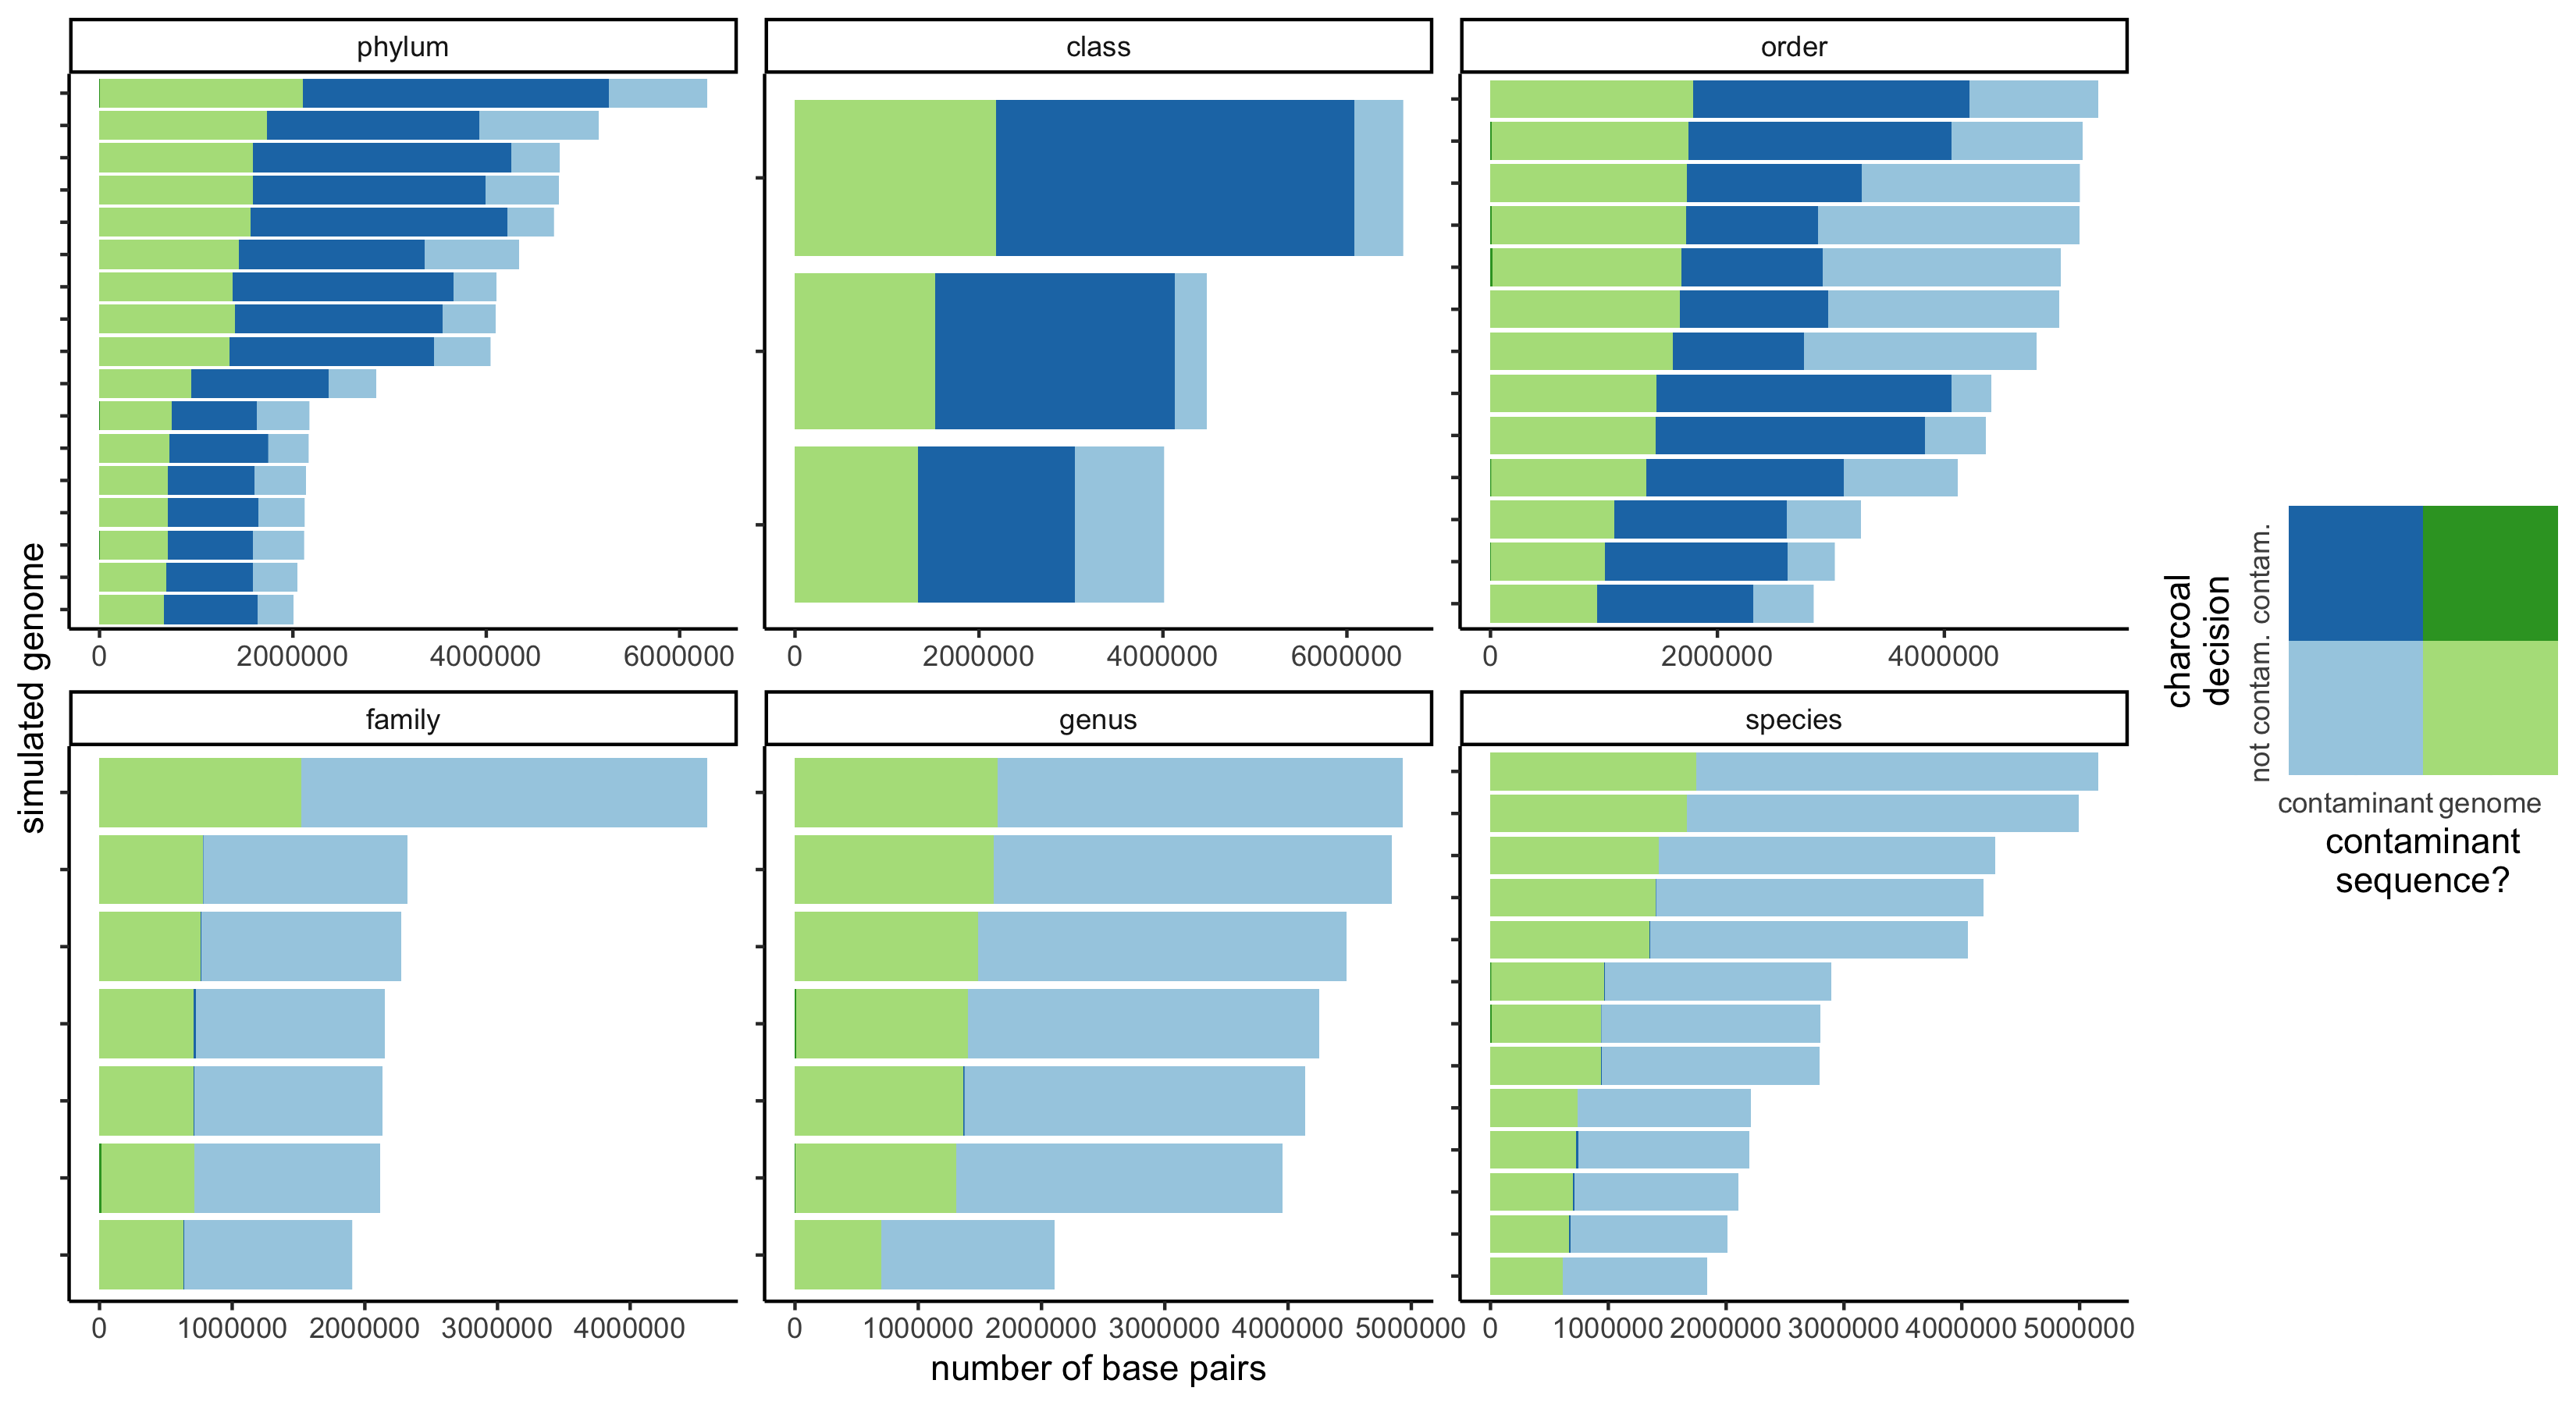

In [321]:
plt1 <- ggpubr::ggarrange(plt, legend_plt, ncol = 2, widths = c(5, 1))
plt1

## bin by contig length to see if contigs that are missed are shorter

Warning message:
“Removed 494 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 494 rows containing non-finite values (stat_signif).”
Warning message:
“Removed 494 rows containing non-finite values (stat_summary).”


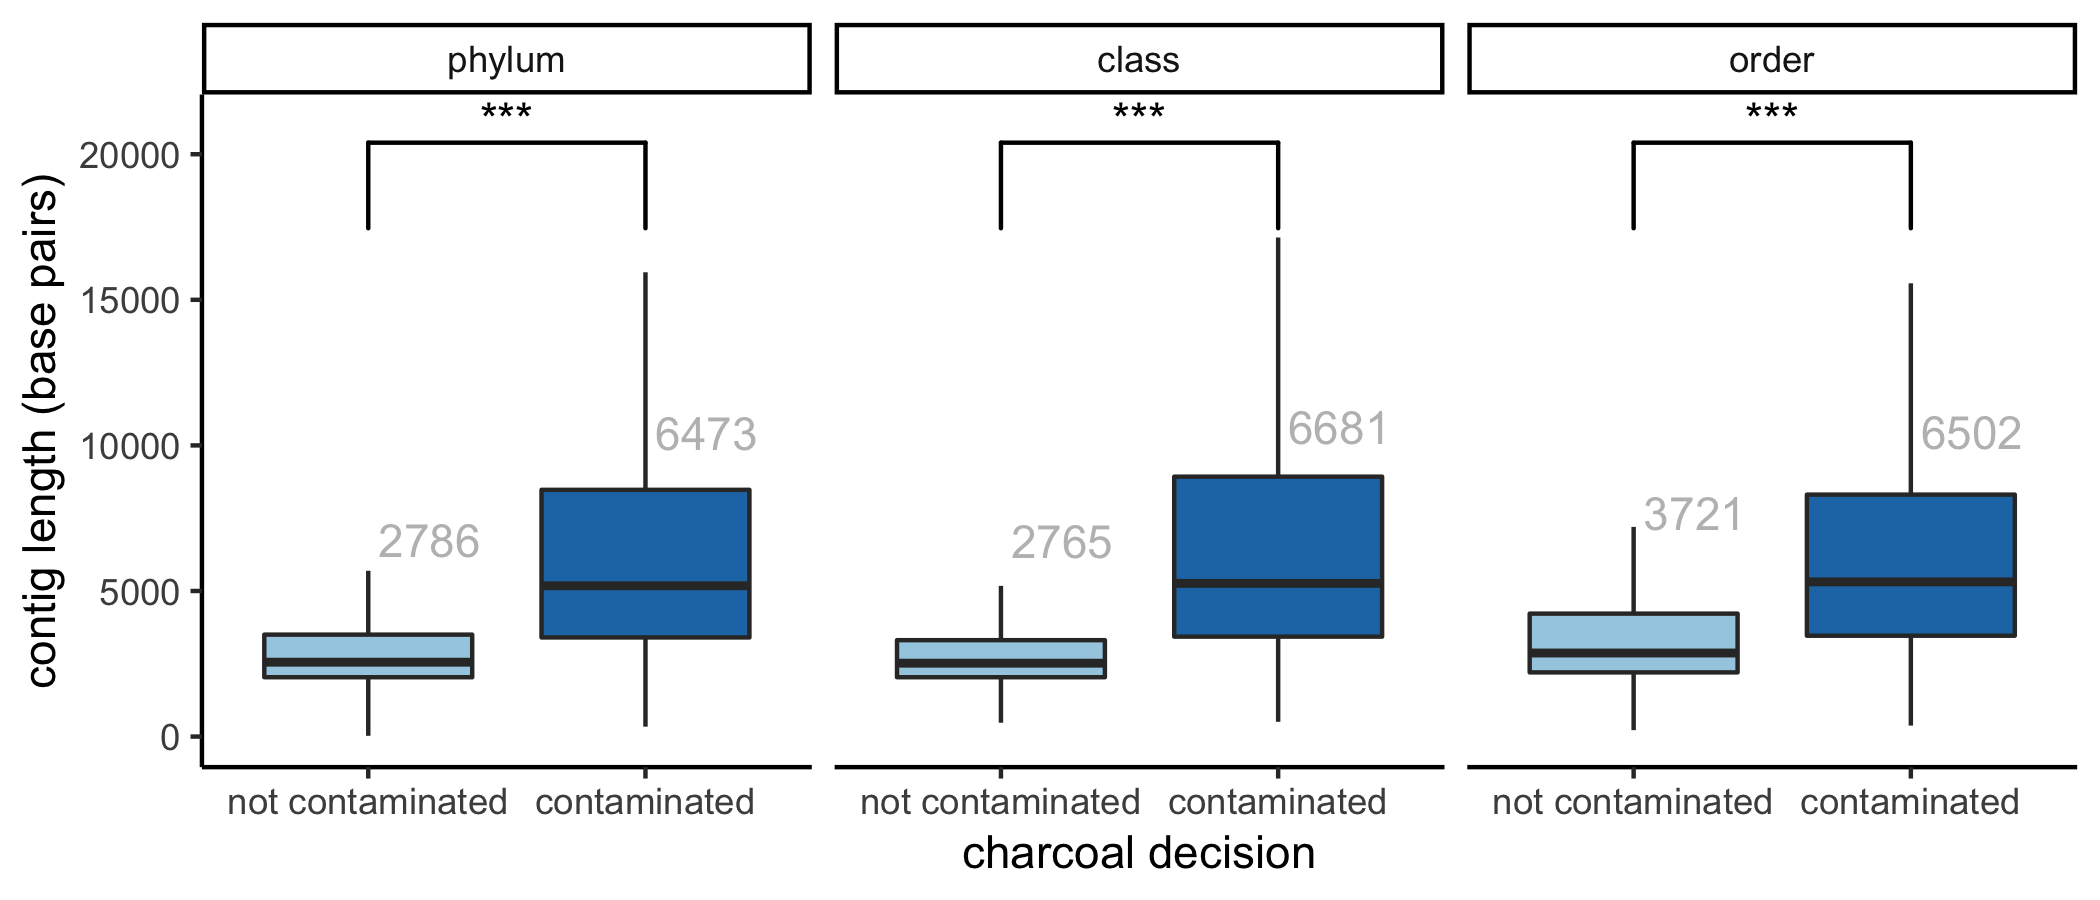

In [314]:
# change default figure size
options(repr.plot.width=7, repr.plot.height=3, repr.plot.res = 300)
plt2 <- ggplot(faidx_rs207_reps_annotated %>%
               filter(gtdb_contamination_level %in% c("phylum", "class", "order")) %>%
               filter(genome_type == "contaminant"), 
              aes(x = type, y = length, fill = type)) +
  #geom_boxplot(outlier.alpha = .1) +
  geom_boxplot(outlier.shape = NA) +
  geom_signif(comparisons = list(c("clean", "dirty")), map_signif_level=TRUE, y_position = 15500) +
  stat_summary(fun = mean, colour="grey", geom= "text", show.legend = FALSE, 
               vjust = -3, hjust = -.1, aes(label = round(..y.., digits=0))) +
  facet_wrap(~gtdb_contamination_level) +
  ylim(c(0, 21000)) +
  #scale_y_log10(limits = c(10, 300000)) +
  theme_classic() +
  scale_fill_manual(values = c("#A6CEE3", "#1F78B4")) + 
  scale_color_manual(values = c("#A6CEE3", "#1F78B4")) +
  scale_x_discrete(labels=c("clean" = "not contaminated", "dirty" = "contaminated")) +
  labs(x = "charcoal decision", y = "contig length (base pairs)") +
  theme(legend.position = "none")
plt2

Warning message:
“Removed 494 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 494 rows containing non-finite values (stat_signif).”
Warning message:
“Removed 494 rows containing non-finite values (stat_summary).”


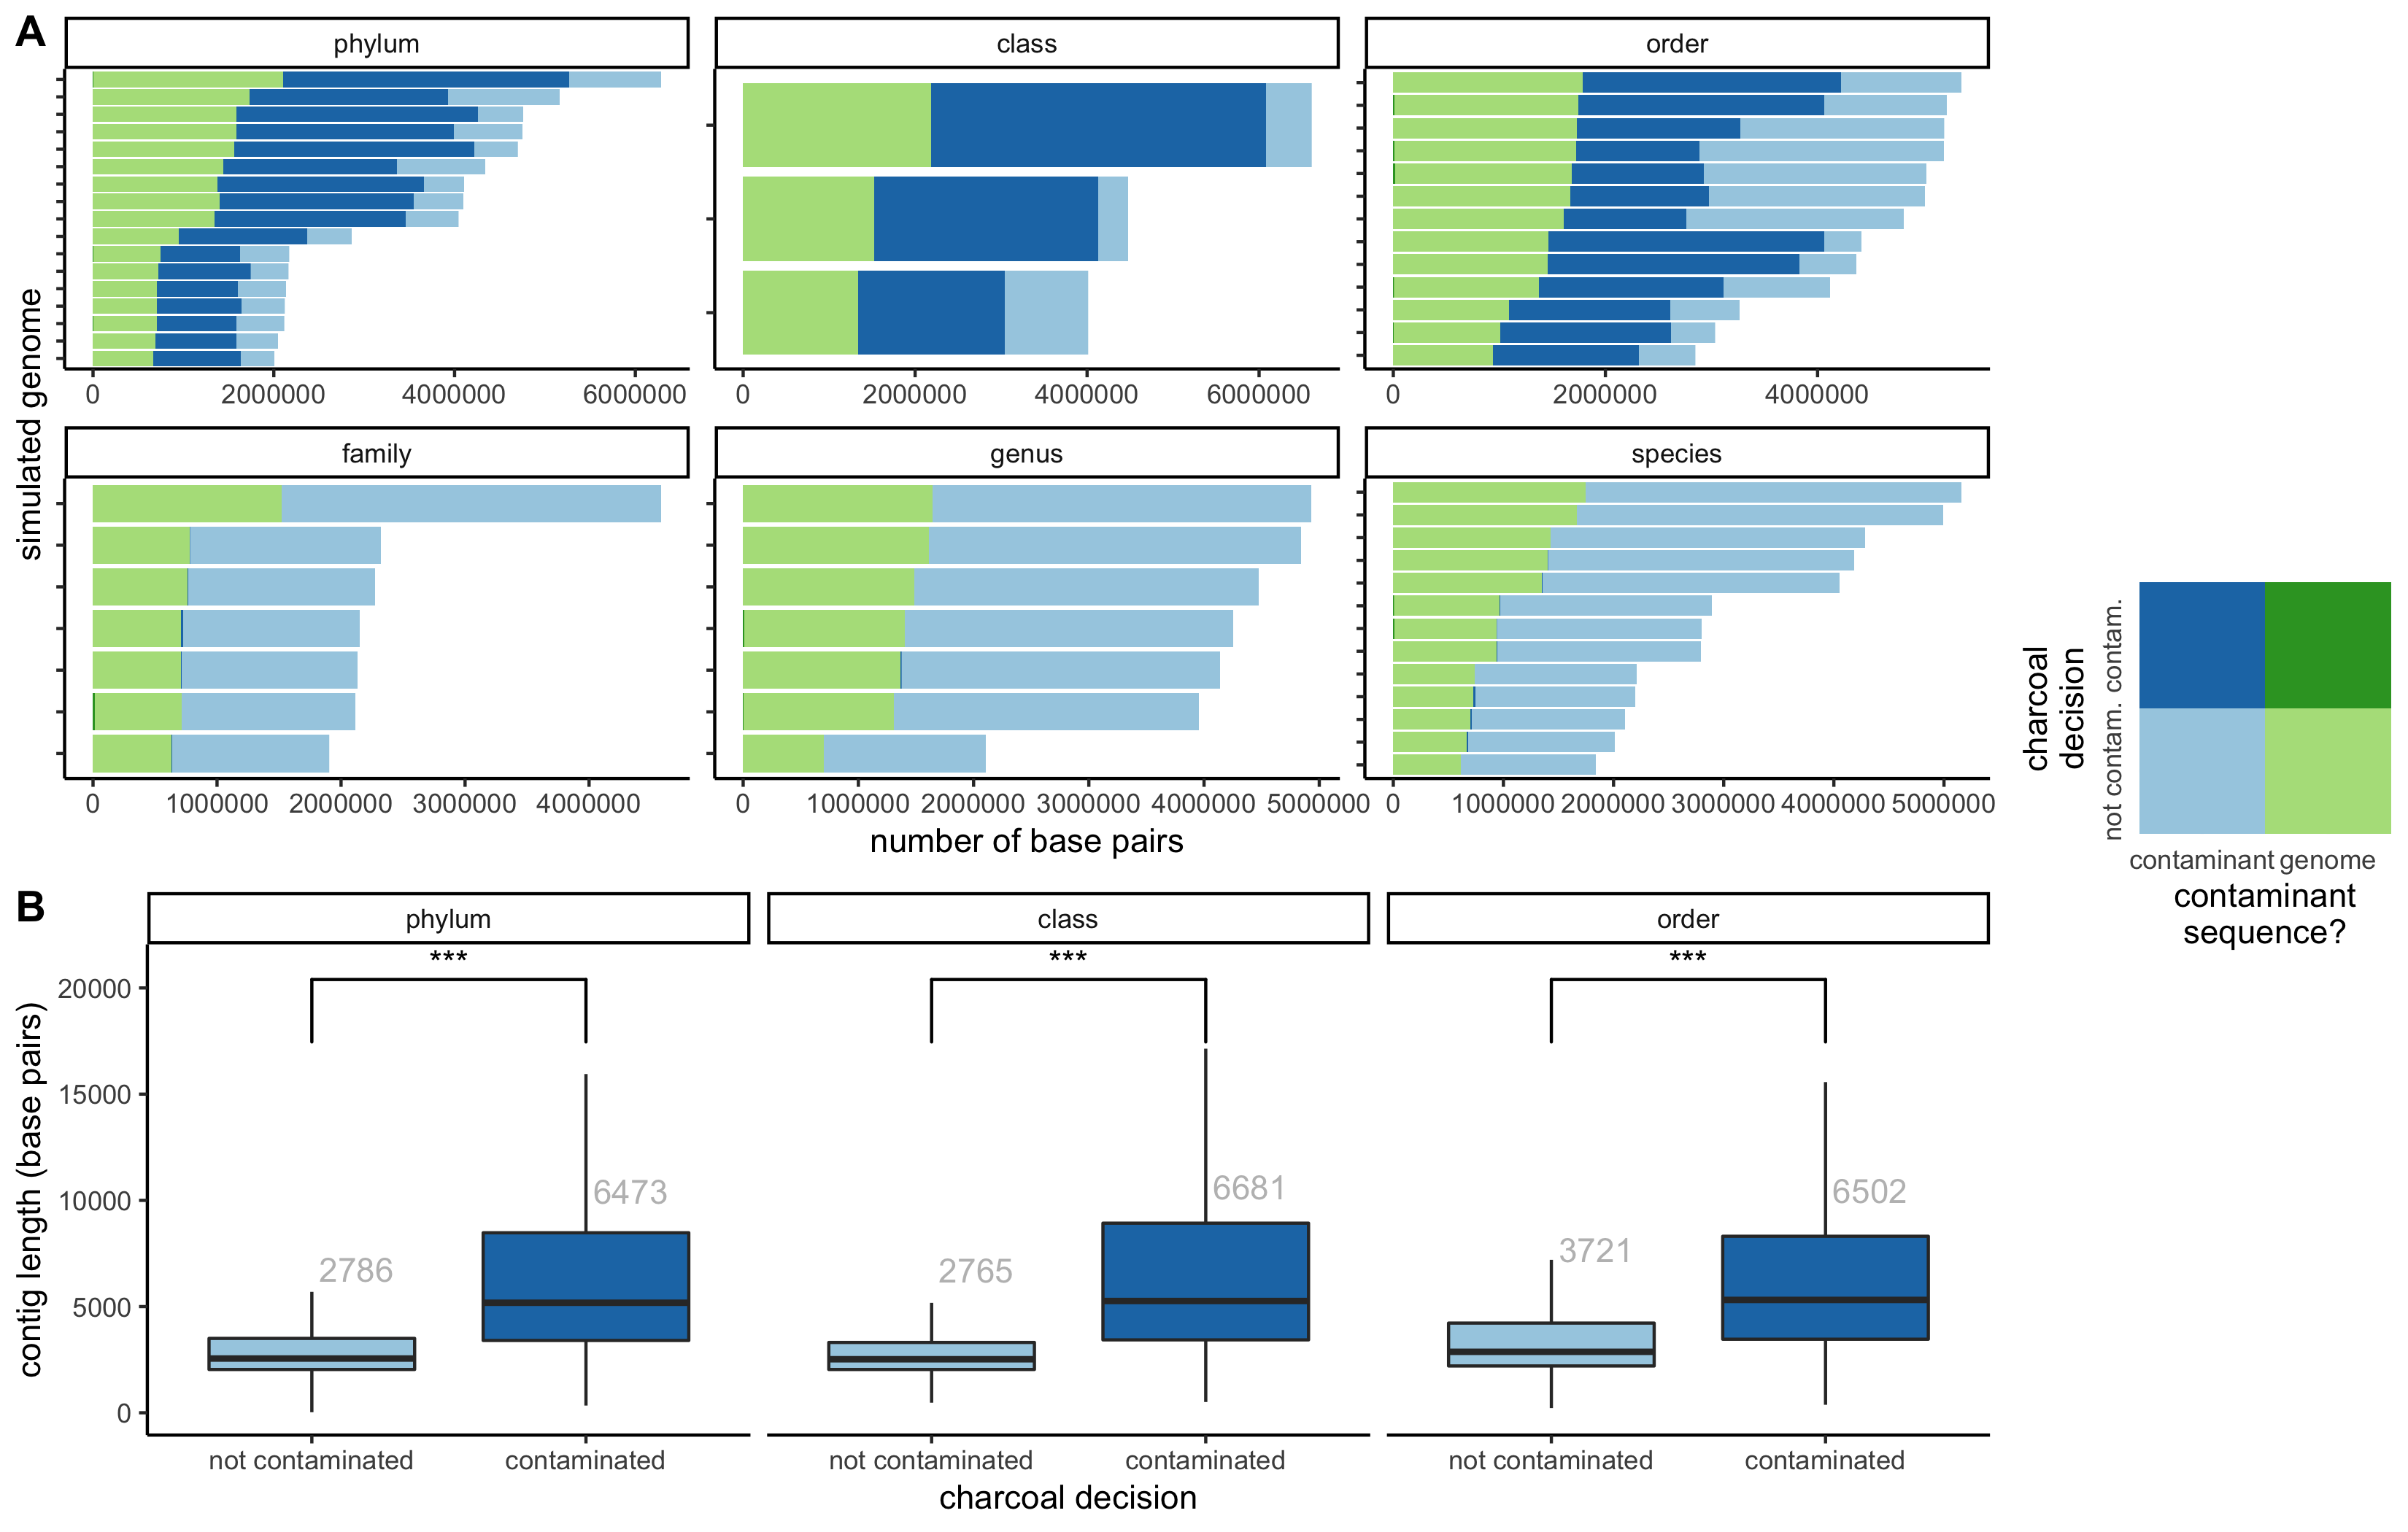

In [327]:
options(repr.plot.width=11, repr.plot.height=7, repr.plot.res = 300)


ggarrange(ggarrange(plt, plt2, labels = c("A", "B"), ncol = 1, heights = c(2, 1.5)),
          legend_plt, widths = c(5, 1))